In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(argparser))) # command line arguments
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # plot patchwork
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridgeline plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # ggplot2 drawing
suppressPackageStartupMessages(suppressWarnings(library(ggplotify))) # ggplot2 drawing

source("../../utils/figure_themes.r")


In [2]:
cell_type <- "PBMC"
model_name <- "MultiClass_MLP"

In [3]:
# set file path for importing the data
training_metrics_file <- file.path(paste0(
    "../../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/training_metrics.parquet"
))

# set output file path for graphs
f1_plot_path <- file.path(paste0(
    "../figures/f1_score.png"
))

# make the output directory if it doesn't exist
dir.create(file.path(paste0(
    "../figures/"
)), showWarnings = FALSE, recursive = TRUE)



# read in the data
training_metrics <- arrow::read_parquet(training_metrics_file)

In [4]:

support <- training_metrics[training_metrics$metric == "support",]
# get apoptosis, healthy, and pyroptosis support rows in one df
support <- support[support$label %in% c("apoptosis", "healthy", "pyroptosis"),]


In [5]:
# get the rows that contain the F1 scores
f1_scores <- training_metrics[training_metrics$metric == "f1-score",]
# remove the rows that contain the macro and weighted averages
f1_scores <- f1_scores[!grepl("macro avg", f1_scores$label),]
f1_scores <- f1_scores[!grepl("weighted avg", f1_scores$label),]
# muatate the label column for multiple cases
f1_scores$label <- gsub("healthy", "Control", f1_scores$label)
f1_scores$label <- gsub("apoptosis", "Apoptosis", f1_scores$label)
f1_scores$label <- gsub("pyroptosis", "Pyroptosis", f1_scores$label)
# mutate the data type column
f1_scores$group <- gsub("train", "Training", f1_scores$group)
f1_scores$group <- gsub("test", "Testing", f1_scores$group)
f1_scores$group <- gsub("validation", "Validation", f1_scores$group)
f1_scores$group <- gsub("treatment_holdout", "Treatment Holdout", f1_scores$group)
f1_scores$group <- gsub("holdout", "Holdout", f1_scores$group)
# factorize the group column
f1_scores$group <- factor(f1_scores$group, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout"
))
# mutate the shuffled_data column
f1_scores$shuffle <- gsub("TRUE", "Shuffled", f1_scores$shuffle)
f1_scores$shuffle <- gsub("FALSE", "Not Shuffled", f1_scores$shuffle)
# cbind the support column to the f1_scores df
f1_scores <- cbind(f1_scores, support$value)
# rename the support column
colnames(f1_scores)[colnames(f1_scores) == "support$value"] <- "support"
# dived the support by 10,000 to get the number of cells
f1_scores$support <- f1_scores$support / 10000
# round the support column to 2 decimal places
f1_scores$support <- round(f1_scores$support, 2)


In [6]:
# make the label a factor so that the order is preserved
f1_scores$label <- factor(
    f1_scores$label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )


F1 score  
### $F1 Score = 2 * \frac{precision * recall}{precision + recall}$
### $Precision = \frac{TP}{TP + FP}$
### $Recall = \frac{TP}{TP + FN}$
### $F1 Score = \frac{2 * TP}{2 * TP + FP + FN}$

In [7]:
head(f1_scores, 1)

,label,metric,value,group,shuffle,support
,<fct>,<chr>,<dbl>,<fct>,<chr>,<dbl>
1,Apoptosis,f1-score,0,Training,Shuffled,9.59


In [8]:
# remove the treatment holdout rows
f1_scores <- f1_scores[grepl("Treatment Holdout", f1_scores$group),]
f1_scores <- f1_scores[grepl("Pyroptosis", f1_scores$label),]

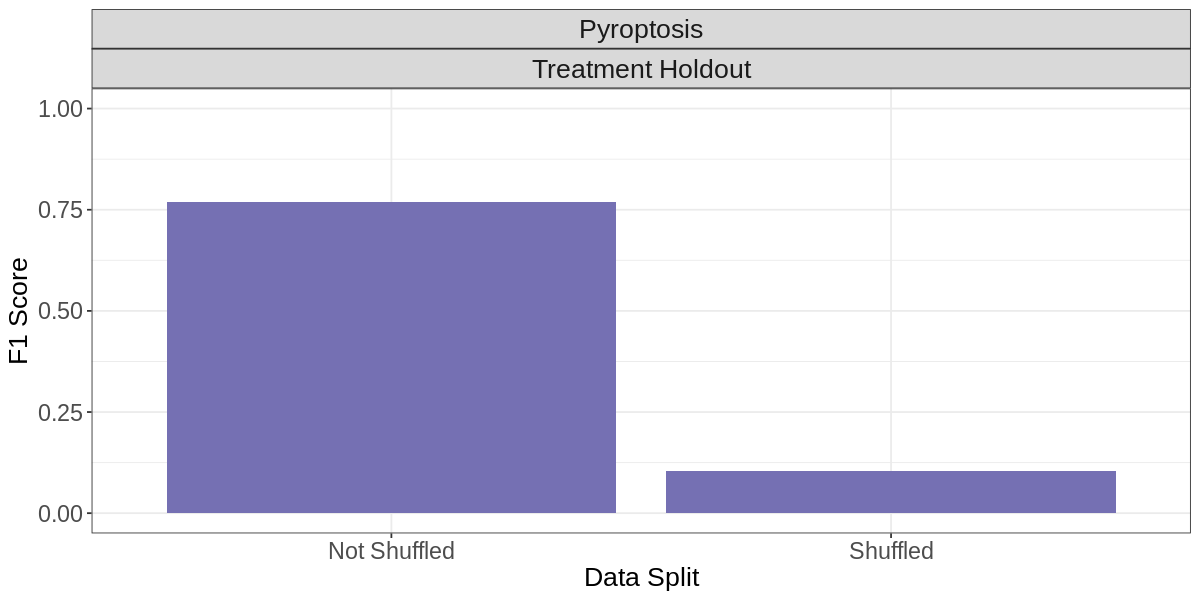

In [9]:
# set plot size
width <- 10
height <- 5
options(repr.plot.width = width, repr.plot.height = height)
# bar plot of the F1 scores
f1_score_plot <- (
    ggplot(f1_scores, aes(x = shuffle, y = value, fill = group))
    + geom_bar(stat = "identity", position = "dodge")

    + ylim(0, 1)
    + facet_wrap(label~group)
    + ylab("F1 Score")
    + xlab("Data Split")
    # change the legend title
    + labs(fill = "Predicted Class")
    # change the colours
    + scale_fill_manual(values = c(
        "Treatment Holdout" = brewer.pal(3, "Dark2")[3]
    ))
    # remove legend
    
    + figure_theme_wide
    + theme(legend.position = "none")

)
ggsave(f1_plot_path, f1_score_plot, width = width, height = height, dpi = 600)
f1_score_plot


## Probabilities

In [10]:
# load in the probabilities
treatment_holdout_probabilities_path <- file.path(
    paste0(
        "../../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/probabilities.parquet"
    )
)
# read in the data from the parquet file
probabilities <- arrow::read_parquet(
    treatment_holdout_probabilities_path
)
head(probabilities,2)

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,labels
<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<lgl>,<chr>,<dbl>,<chr>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.1163489,0.4907182,0.3929329,2,1,train,TRUE,pyroptosis,2534673,PBMC,⋯,169,LPS,10.000_µg_per_ml,95.86607,128.3363,111,143,87,117,healthy
0.1103378,0.4905671,0.3990950,1,1,train,TRUE,healthy,1010528,PBMC,⋯,604,LPS_Nigericin,100.000_µg_per_ml_10.000_µM,244.81614,477.4955,258,489,233,466,pyroptosis


In [11]:
unique(probabilities$data_split)
unique(probabilities$shuffle)

[1] "train"             "validation"        "testing"          
[4] "treatment_holdout" "holdout"

[1]  TRUE FALSE

In [12]:
# replace label_true value 1 with Control
probabilities$label_true <- gsub("1", "Control", probabilities$label_true)
# replace label_true value 2 with pyroptosis
probabilities$label_true <- gsub("2", "Pyroptosis", probabilities$label_true)
# replace label_true value 0 with apoptosis
probabilities$label_true <- gsub("0", "Apoptosis", probabilities$label_true)

# replace label_pred value 1 with Control
probabilities$label_pred <- gsub("1", "Control", probabilities$label_pred)
# replace label_pred value 2 with pyroptosis
probabilities$label_pred <- gsub("2", "Pyroptosis", probabilities$label_pred)
# replace label_pred value 0 with apoptosis
probabilities$label_pred <- gsub("0", "Apoptosis", probabilities$label_pred)

# replace shuffled value TRUE with Shuffled
probabilities$shuffle <- gsub("TRUE", "Shuffled", probabilities$shuffle)
# replace shuffled value FALSE with Not Shuffled
probabilities$shuffle <- gsub("FALSE", "Not Shuffled", probabilities$shuffle)

# replace data_split value treatment_holdout with Treatment Holdout|
probabilities$data_split <- gsub("treatment_holdout", "Treatment Holdout", probabilities$data_split)
# replace data_split value holdout with Holdout
probabilities$data_split <- gsub("holdout", "Holdout", probabilities$data_split)
# replace training value train with Training
probabilities$data_split <- gsub("train", "Training", probabilities$data_split)
# replace testing value test with Testing
probabilities$data_split <- gsub("testing", "Testing", probabilities$data_split)
# replace validation value validation with Validation
probabilities$data_split <- gsub("validation", "Validation", probabilities$data_split)


In [13]:
head(probabilities, 2)
unique(probabilities$shuffle)

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,labels
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.1163489,0.4907182,0.3929329,Pyroptosis,Control,Training,Shuffled,pyroptosis,2534673,PBMC,⋯,169,LPS,10.000_µg_per_ml,95.86607,128.3363,111,143,87,117,healthy
0.1103378,0.4905671,0.3990950,Control,Control,Training,Shuffled,healthy,1010528,PBMC,⋯,604,LPS_Nigericin,100.000_µg_per_ml_10.000_µM,244.81614,477.4955,258,489,233,466,pyroptosis


[1] "Shuffled"     "Not Shuffled"

In [14]:
# change the label columns to be factors
probabilities$label_true <- factor(probabilities$label_true , levels = c(
    "Control", "Apoptosis", "Pyroptosis"
))
probabilities$label_pred <- factor(probabilities$label_pred , levels = c(
    "Pyroptosis", "Apoptosis", "Control"
))
# change the data_split column to be a factor
probabilities$data_split <- factor(probabilities$data_split, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout"
))
# change the shuffled_data column to be a factor
probabilities$shuffle <- factor(probabilities$shuffle, levels = c(
    "Not Shuffled", "Shuffled"
))

# remove treatment holdout rows
probabilities <- probabilities[grepl("Treatment Holdout", probabilities$data_split),]

Picking joint bandwidth of 0.0139

Picking joint bandwidth of 0.00515



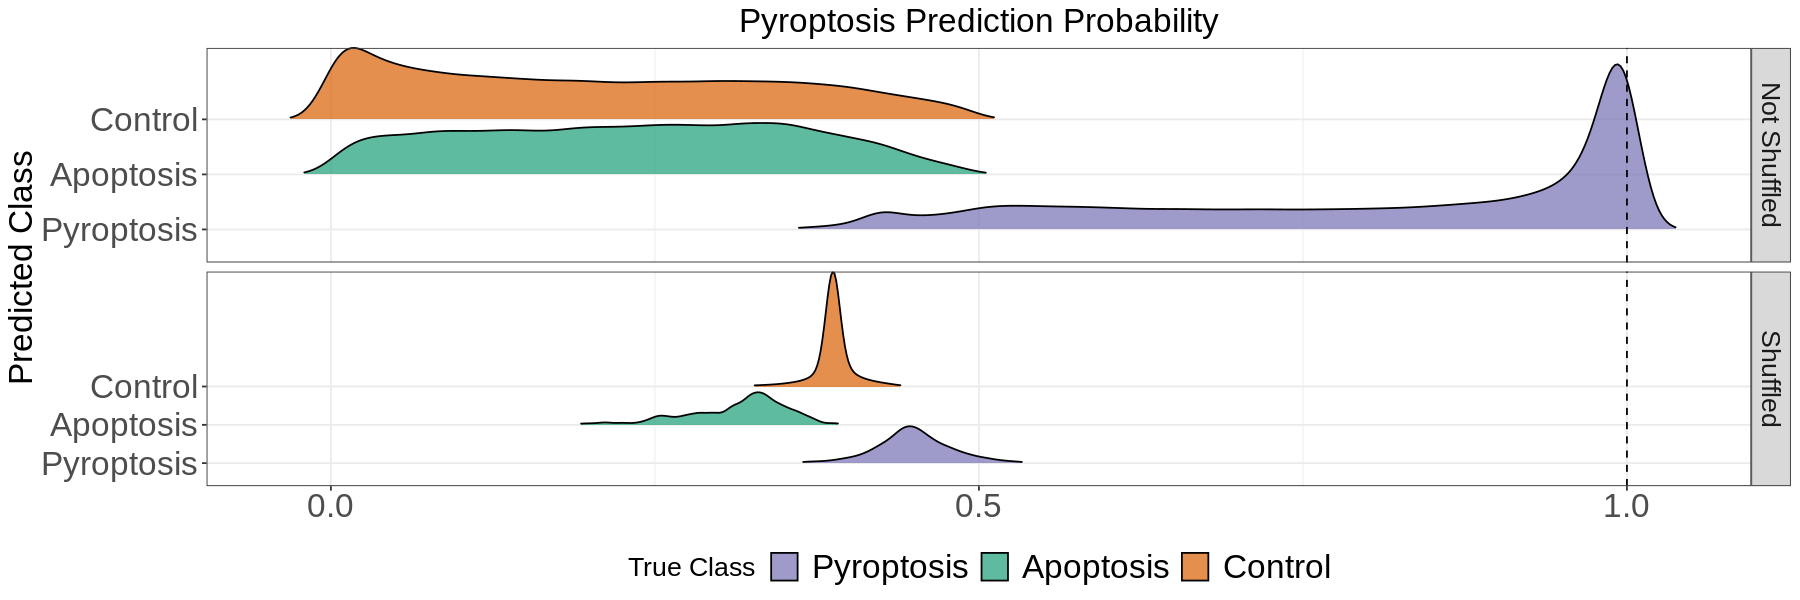

In [15]:
height <- 5
width <- 15
options(repr.plot.width = width, repr.plot.height = height)

ridge_plot_pyroptosis <- (
    ggplot(probabilities, aes(x = pyroptosis_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + facet_grid(.~data_split)
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + facet_grid(shuffle ~ ., scales = "free_y")
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + labs(title = "Pyroptosis Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    
    # remove legend
    # make title larger
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    + theme(legend.position = "bottom", legend.direction = "horizontal")
    # remove x axis label
    + theme(axis.title.x = element_blank())
    # add vertical line at 1 
)
ridge_plot_pyroptosis


In [16]:
# get the legend
legend <- get_legend(ridge_plot_pyroptosis)
ridge_plot_pyroptosis <- (
    # remove the legend
    ridge_plot_pyroptosis + theme(legend.position = "none")
)

Picking joint bandwidth of 0.0139

Picking joint bandwidth of 0.00515



### Patch the individual facet grids together for a figure sub-panel

Picking joint bandwidth of 0.0139

Picking joint bandwidth of 0.00515



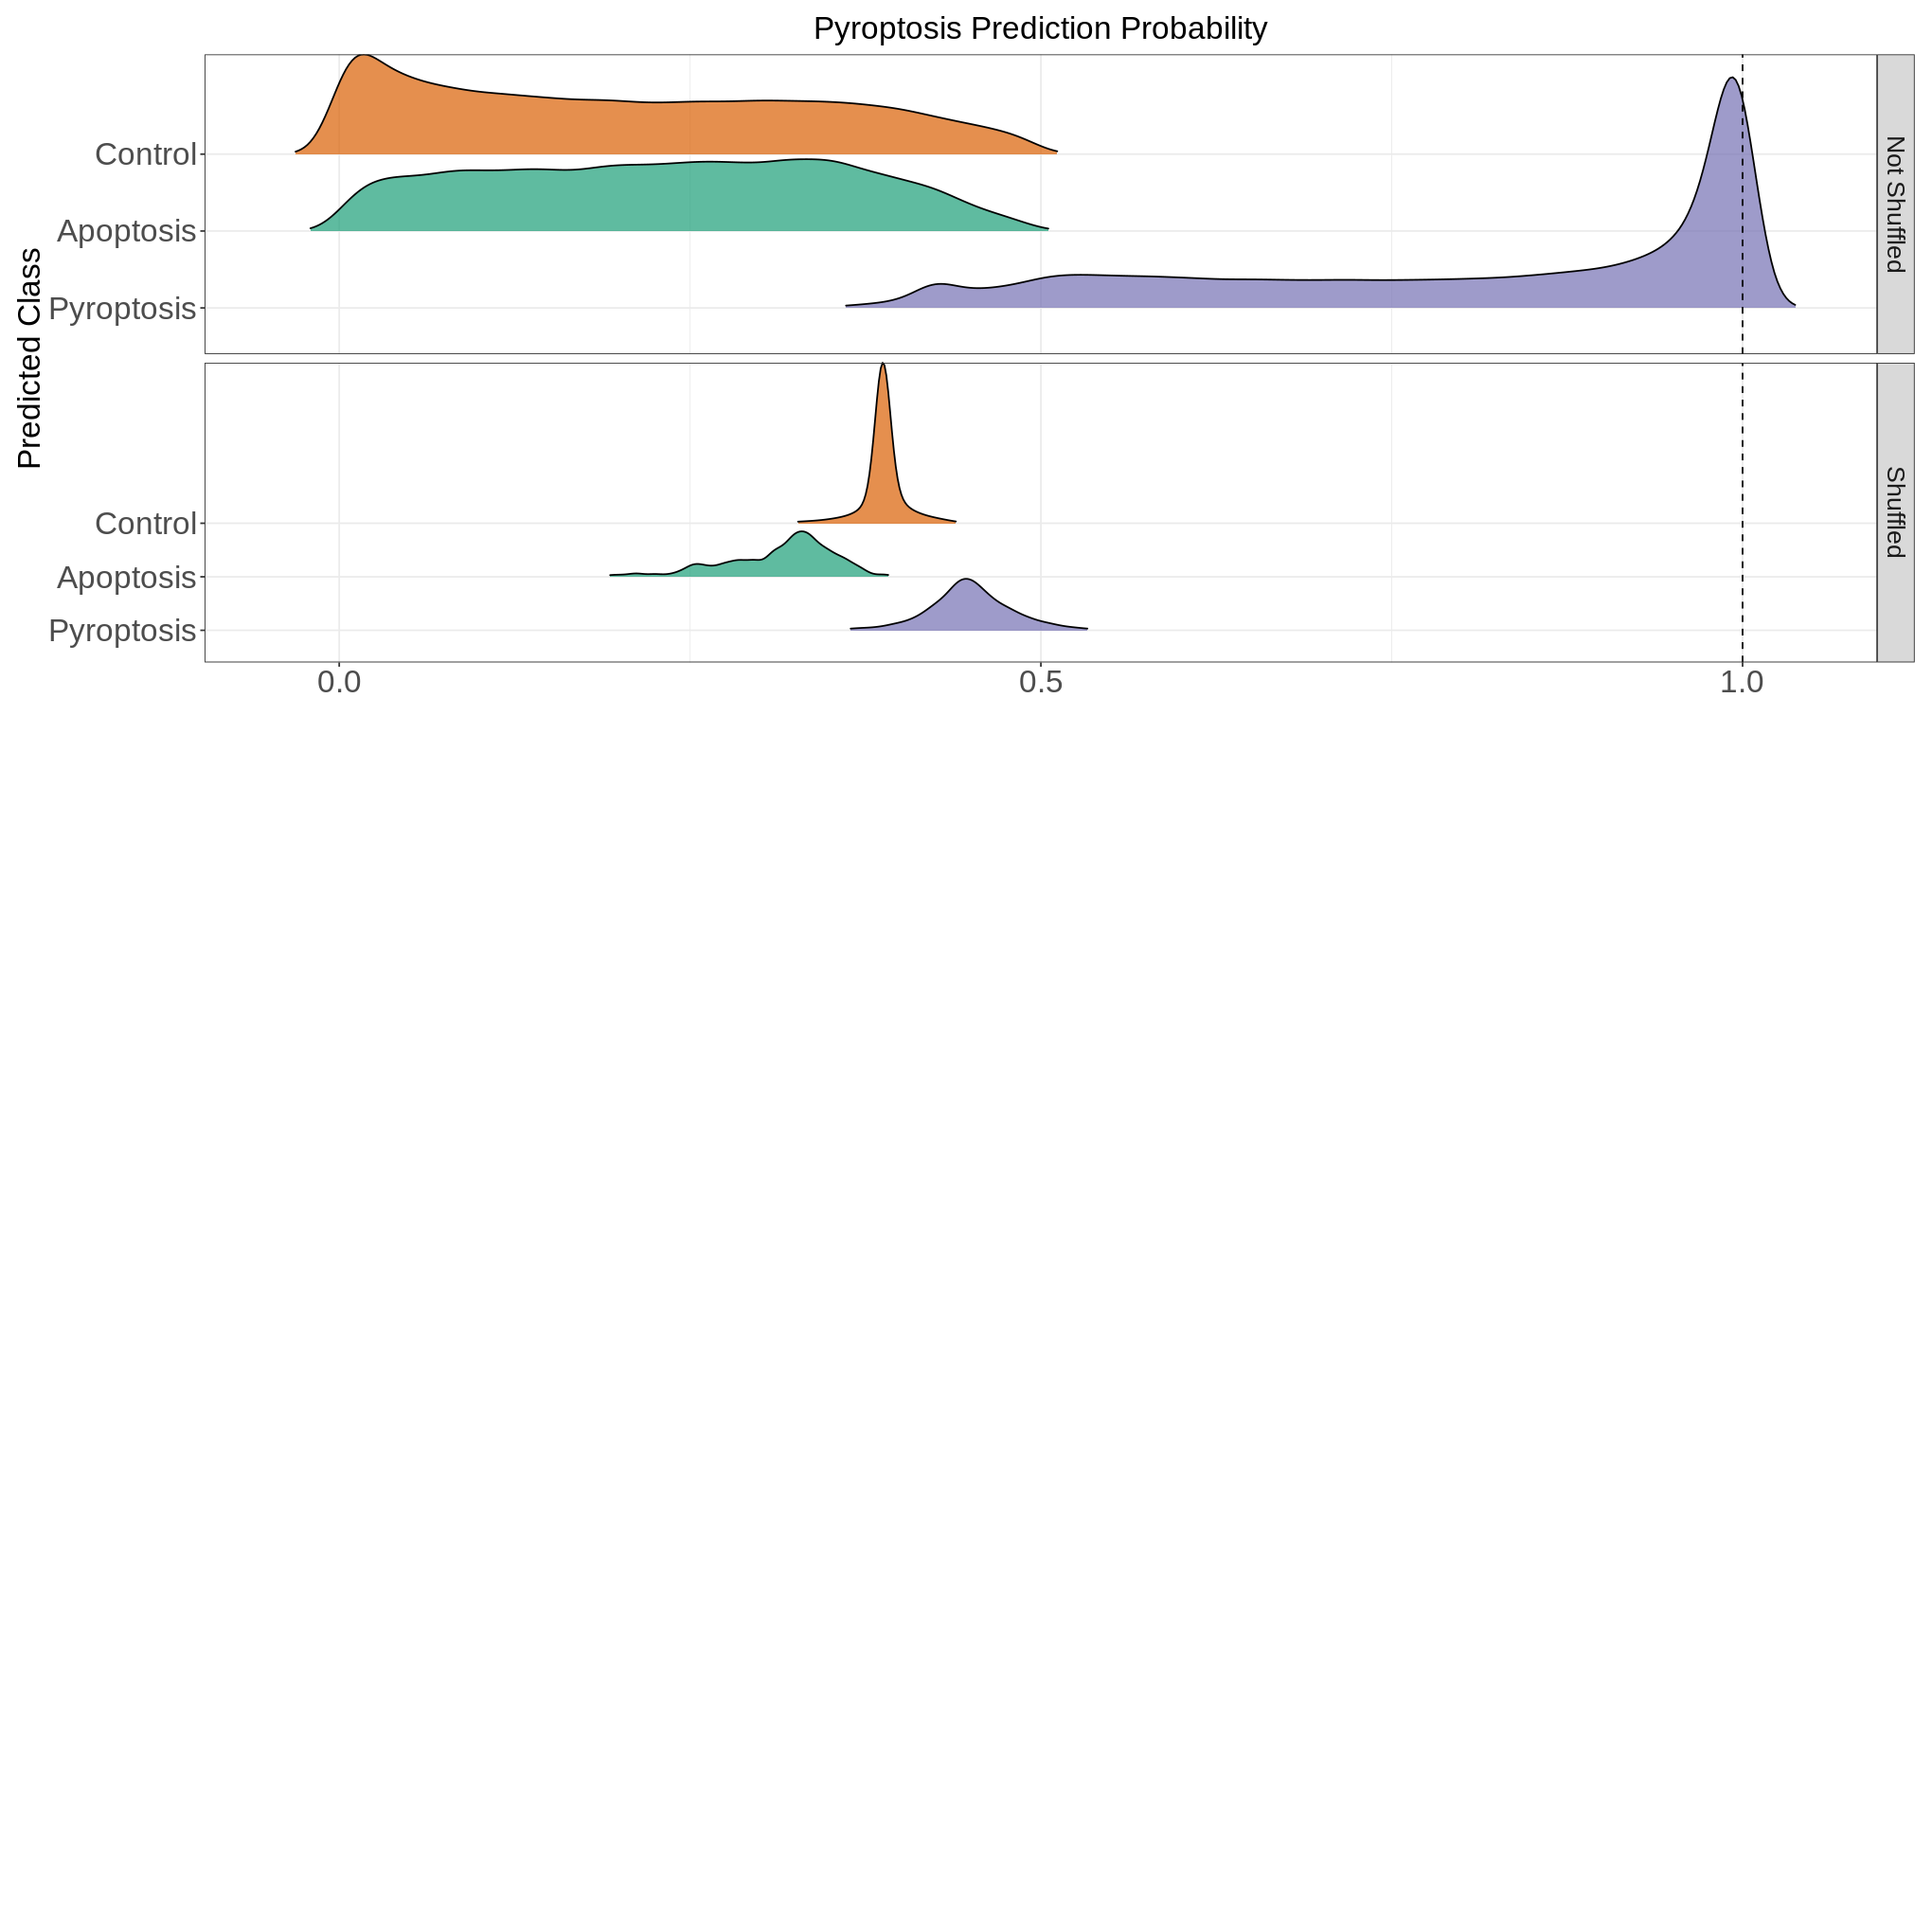

In [17]:
# ridge_plot_pyroptosis
# patch the plots together via the patchwork package
layout <- c(
    area(t=1, b=2, l=1, r=1), # A
    area(t=3, b=4, l=1, r=1), # B
    area(t=5, b=6, l=1, r=1)  # C
)
# set plot size
width <- 17
height <- 17
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)
fig5_probabilities <- (
    ridge_plot_pyroptosis
    + plot_layout(design = layout)
)
fig5_probabilities

## single cell predictions 

In [18]:
sc_preds_path <- file.path(
    paste0(
        "../../../8.cytopick_analysis/results/PBMC/single_cell_predictions.parquet"
    )
)
# read in the data from the parquet file
sc_preds <- arrow::read_parquet(
    sc_preds_path
)
head(sc_preds,2)


apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,labels,correct,image_path,image_crop_path
<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<lgl>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>
0.05300940,0.2277694,0.7192212,2,2,train,TRUE,pyroptosis,3599724,PBMC,⋯,333.5562,701.6192,345,713,323,690,pyroptosis,TRUE,/home/lippincm/Documents/ML/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_shuffled_train_df_im1_im3_im4_composite_image_cell_0.png,/home/lippincm/Documents/ML/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_shuffled_train_df_im1_im3_im4_composite_image_crop_cell_0.png
0.06975055,0.2418882,0.6883612,2,2,train,TRUE,pyroptosis,724498,PBMC,⋯,613.5830,1752.8745,623,1762,605,1745,pyroptosis,TRUE,/home/lippincm/Documents/ML/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_shuffled_train_df_im1_im3_im4_composite_image_cell_1.png,/home/lippincm/Documents/ML/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_shuffled_train_df_im1_im3_im4_composite_image_crop_cell_1.png


In [19]:
# define df subsets for each class, data split
pyroptosis_correct_treatment_holdout <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "treatment_holdout",]


# make a list of the data frames for each class
correct_class_dfs <- list(
    pyroptosis_correct_treatment_holdout
)



In [20]:
width <- 2
height <- 2
options(repr.plot.width = width, repr.plot.height = height)
# define function to return the image object
get_image <- function(df, i){
    # Load the PNG file
    img <- png::readPNG(df$image_crop_path[i])
    # Convert the image to a raster object
    g <- grid::rasterGrob(img, interpolate=TRUE)

    # Create a ggplot
    p <- ggplot() +
    annotation_custom(g, xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf) +
    theme_void()  # Remove axes and labels

    # Print the plot
    return(p)
}


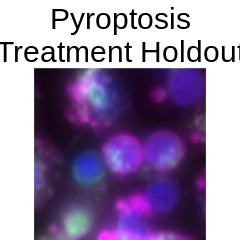

In [21]:
pyroptosis_correct_treatment_holdout_image <- get_image(pyroptosis_correct_treatment_holdout, 1)
# add the title
pyroptosis_correct_treatment_holdout_image <- (
    pyroptosis_correct_treatment_holdout_image 
    + ggtitle("Pyroptosis\n(Treatment Holdout)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))

)


# make a list of the images
correct_class_images <- list(
    pyroptosis_correct_treatment_holdout_image
)
pyroptosis_correct_treatment_holdout_image


Picking joint bandwidth of 0.0139

Picking joint bandwidth of 0.00515



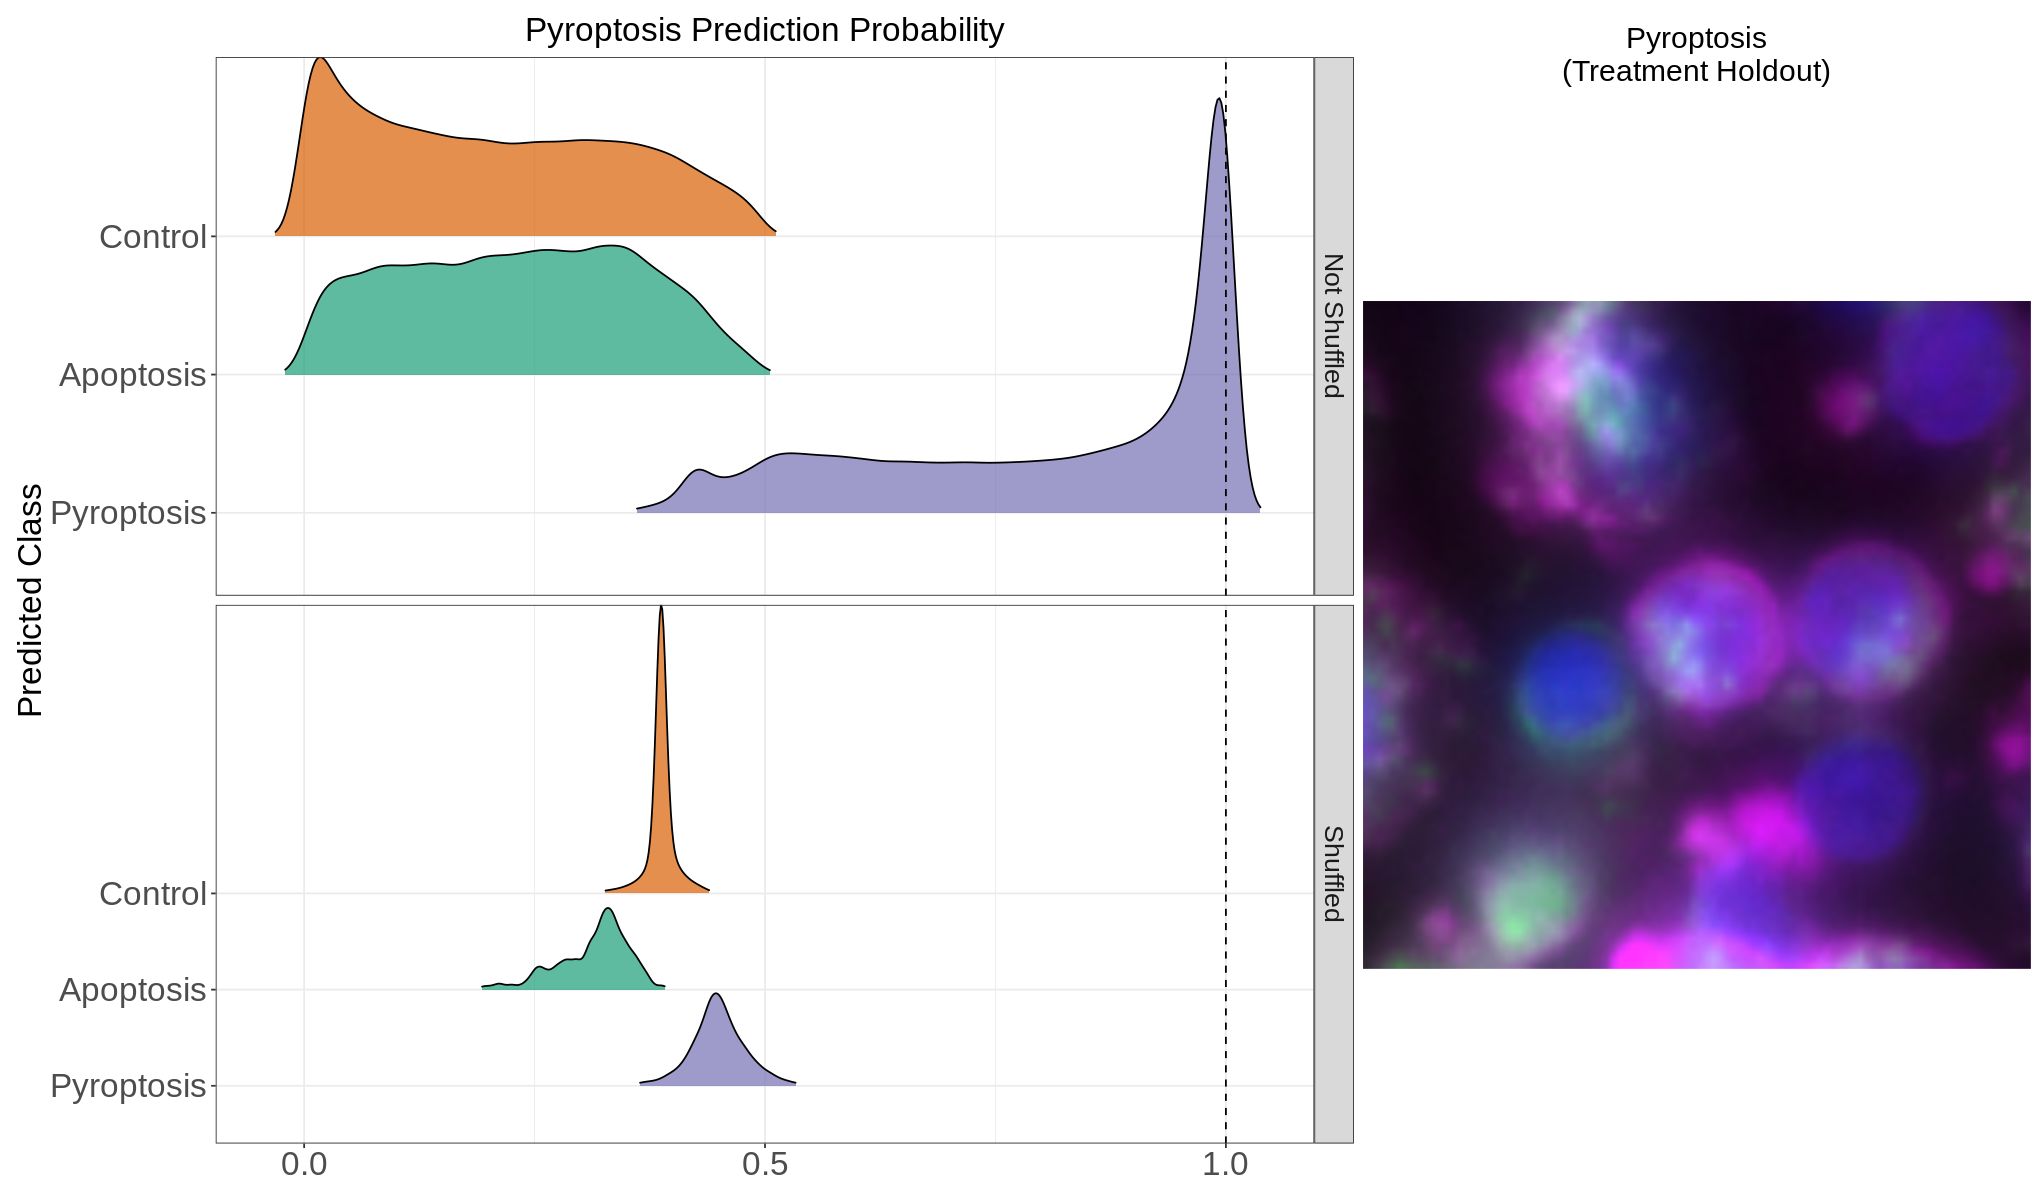

In [22]:
width <- 17
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# new layout for pyroptosis legend
layout <- c(
    # 1 row 5 columns with the first column being wider than the rest
    area(t=1, b=1, l=1, r=4), # A
    area(t=1, b=1, l=5, r=6) # B
)

pyroptosis_correct_treatment_holdout_image <- (

        wrap_elements(full = ridge_plot_pyroptosis)
        + pyroptosis_correct_treatment_holdout_image

    + plot_layout(design = layout)
)

pyroptosis_correct_treatment_holdout_image 

### Patch the plots together

In [23]:
# # convert each plot to a ggplot object
# f1_score_plot <- as.grob(f1_score_plot)
# pyroptosis_correct_treatment_holdout_image <- as.grob(pyroptosis_correct_treatment_holdout_image)
# f1_score_plot

Picking joint bandwidth of 0.0139

Picking joint bandwidth of 0.00515

Picking joint bandwidth of 0.0139

Picking joint bandwidth of 0.00515



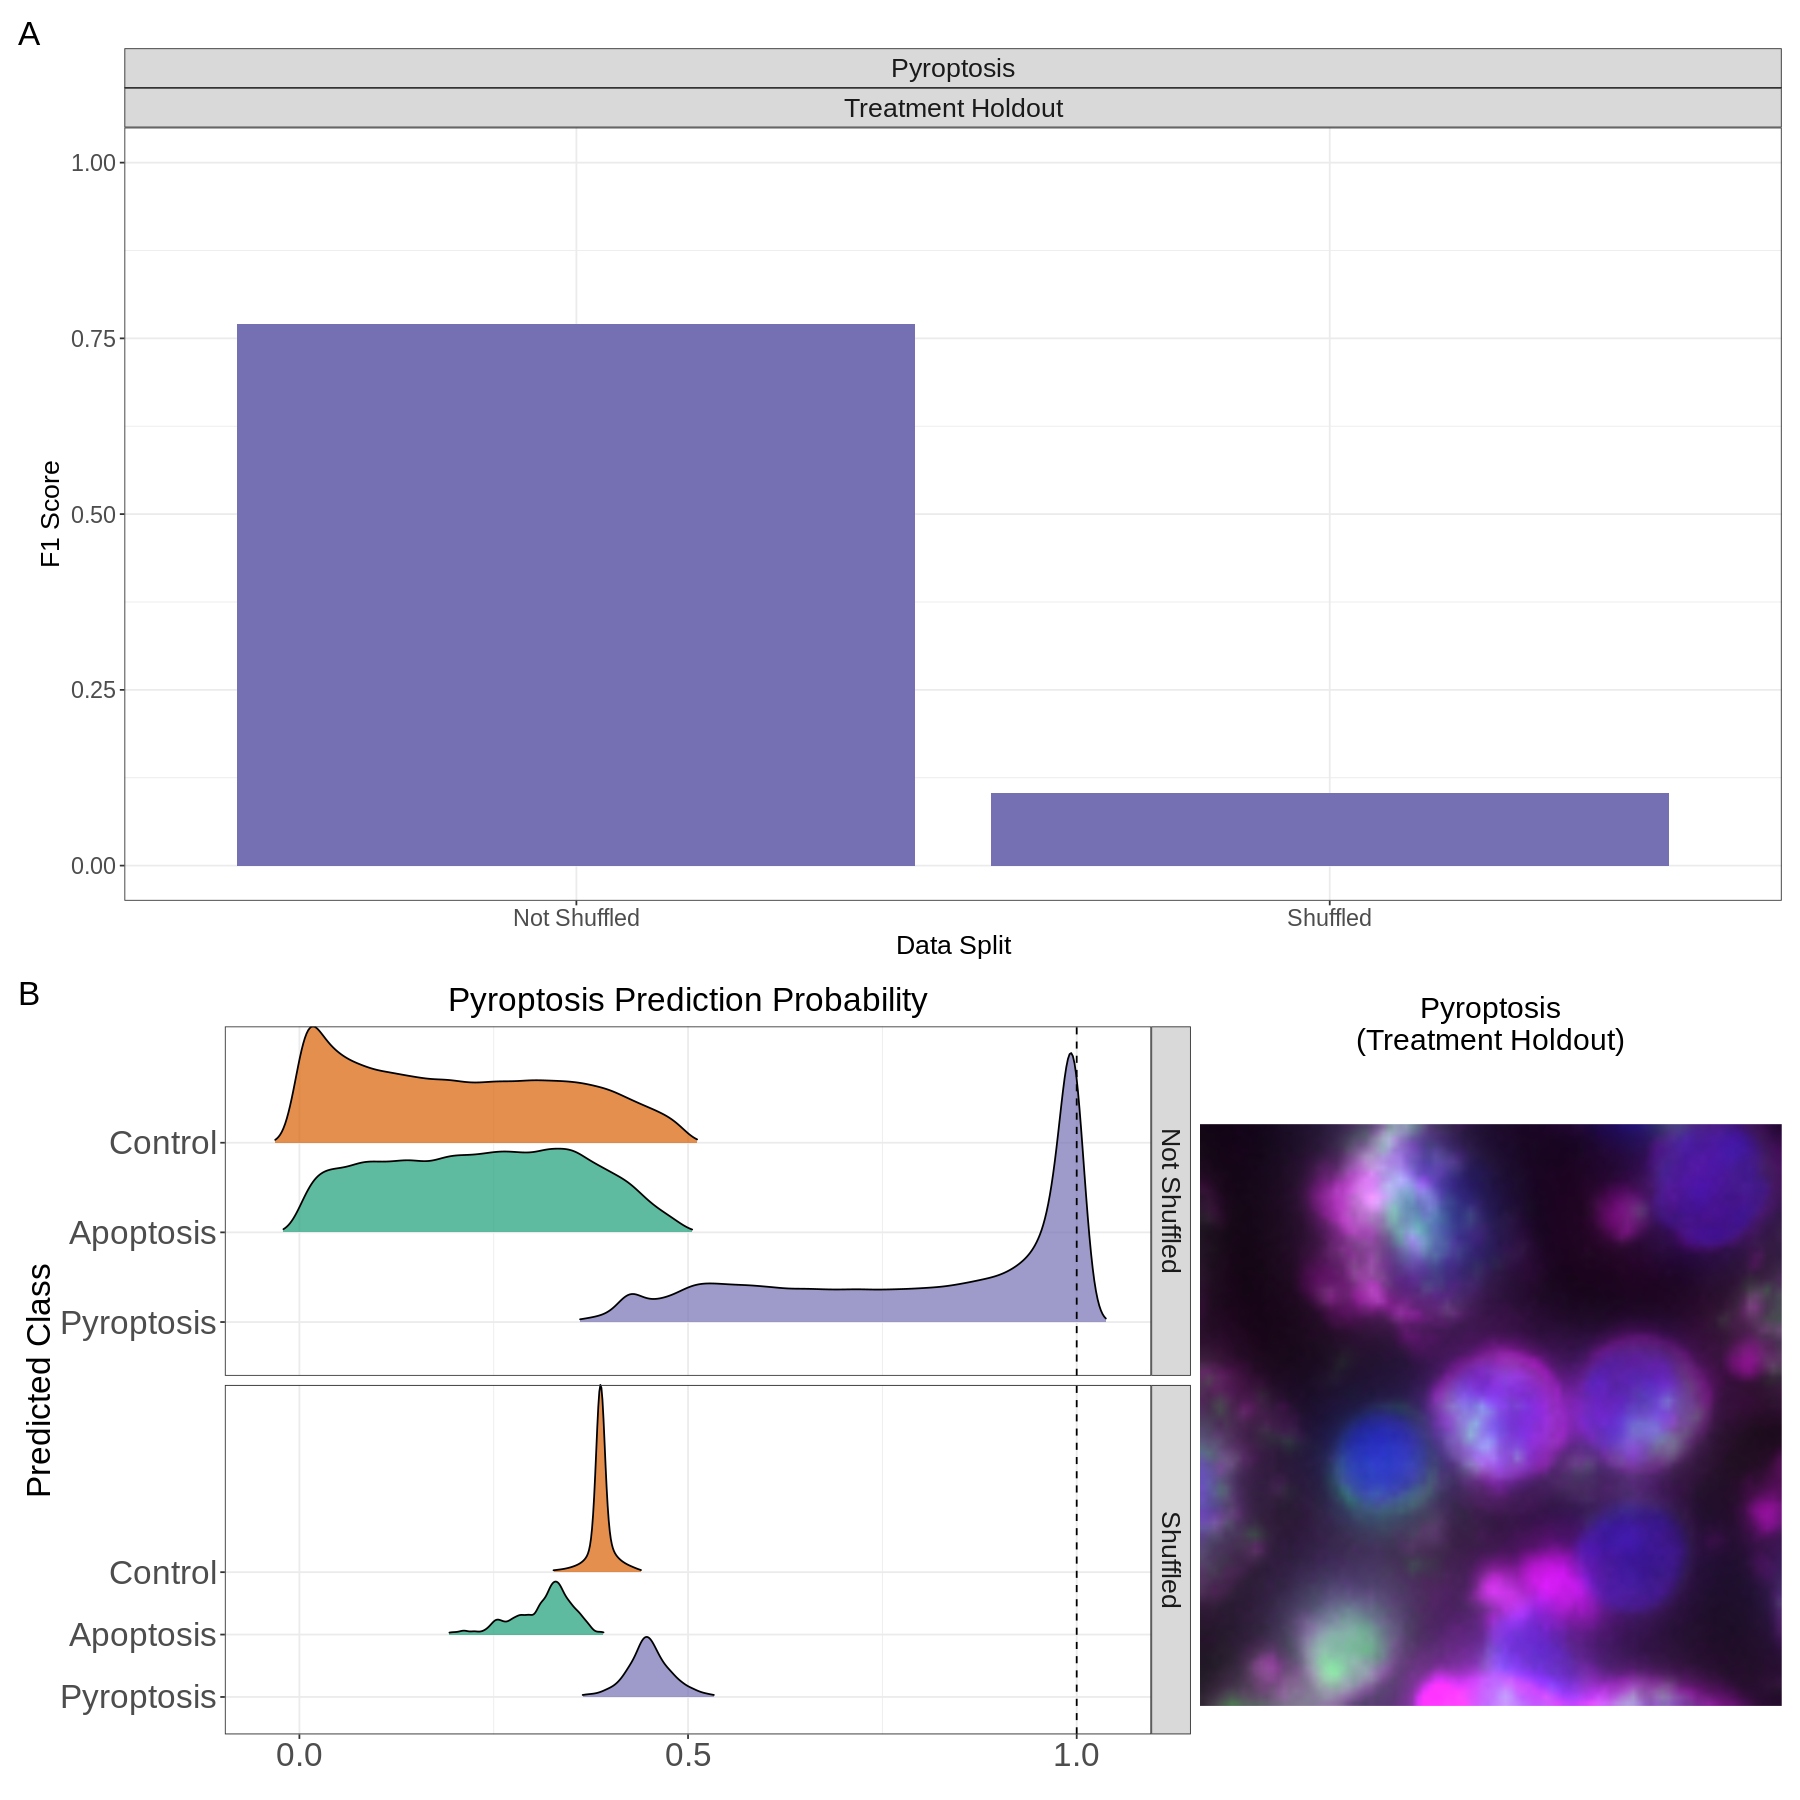

In [24]:
layout <- c(
    area(t=1, b=2, l=1, r=2), # A
    area(t=3, b=4, l=1, r=2) # B

)
# set plot size
width <- 15
height <- 15
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)
figs10 <- (
    f1_score_plot
    + wrap_elements(full = pyroptosis_correct_treatment_holdout_image)    
    + plot_layout(design = layout, widths = c(10, 10))
    # make bottom plot not align
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 20))
)
figs10

# save the plot

ggsave("../figures/S10.png", figs10, width = width, height = height, dpi = 600)
